# Selecting a performance measure

We are working on the bank dataset, which includes both categorical and numerical features. For that reason we need a custom error function, we combine the cross-entropy loss for categorical columns and RMSE for numerical columns, weighted by the ratio of the number of columns for each type. Our error function is: $$ E = w_{\text{cat}} \cdot CE + w_{\text{num}} \cdot RMSE $$
<br>
Where:
- $w_{\text{cat}} = \frac{n_{\text{cat}}}{n_{\text{cat}} + n_{\text{num}}}$
- $w_{\text{num}} = \frac{n_{\text{num}}}{n_{\text{cat}} + n_{\text{num}}}$
- $n_{\text{cat}} = \text{Number of categorical columns}$
- $n_{\text{num}} = \text{Number of numerical columns}$
<br>
And:
- $\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}$
- $\text{CE} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^{K} y_{i,k} \log(\hat{y}_{i,k})$
- $y_i = \text{True value for the } i\text{-th data point (numerical)}$
- $\hat{y}_i = \text{Imputed (predicted) value for the } i\text{-th data point (numerical)}$
- $N = \text{Number of missing values (numerical or categorical)}$
- $y_{i,k} = \text{One-hot encoded true value for the } i\text{-th data point and } k\text{-th class}$
- $\hat{y}_{i,k} = \text{Predicted probability for the } k\text{-th class for the } i\text{-th data point}$
- $K = \text{Number of classes for the categorical column.}$

# Download the data

In [458]:
import pandas as pd

#bank_df = pd.read_csv("./data/bank-full.csv", sep=";")
from google.colab import drive
drive.mount('/content/drive')
bank_df=pd.read_csv("/content/drive/MyDrive/projet_bi/bank-full.csv", sep=";")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Take a quick look at the Data

In [459]:
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [460]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [461]:
bank_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


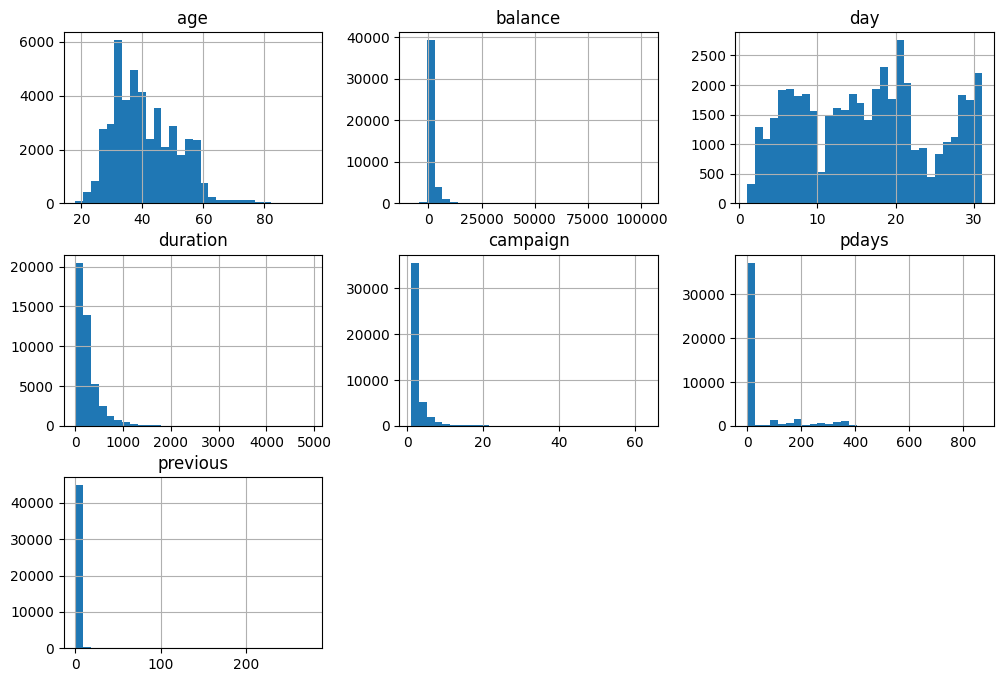

In [462]:
import matplotlib.pyplot as plt

bank_df.hist(bins=30, figsize=(12,8))
plt.show()

# Create a Test Set

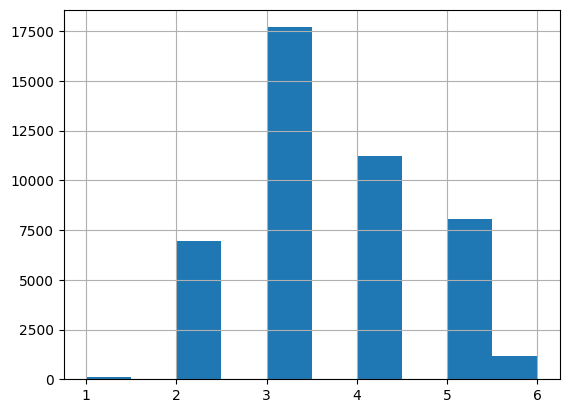

In [463]:
import numpy as np

bank_df["Age_cat"] = pd.cut(bank_df["age"],
                            bins=[10, 20, 30, 40, 50, 60, np.inf],
                            labels=[1, 2, 3, 4, 5, 6])

bank_df.Age_cat.hist(bins=10)
plt.show()

In [464]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(bank_df, test_size=0.4, stratify=bank_df["Age_cat"], random_state=42)

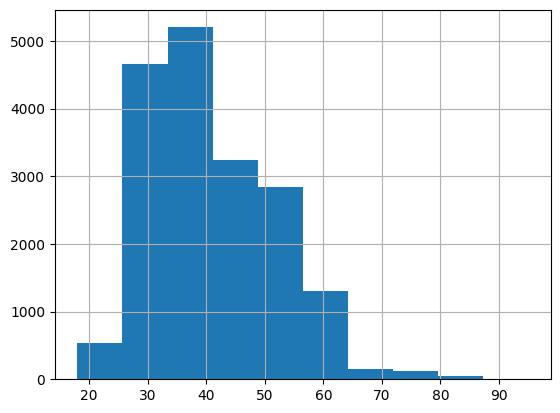

In [465]:
test_set["age"].hist()
plt.show()

In [466]:
# Drop Age_cat column because we won't use it again
for set_ in (train_set, test_set):
    set_.drop(["Age_cat", "y"], axis=1, inplace=True)

In [467]:
train_set_clean = train_set.copy()

In [468]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27126 entries, 6944 to 25943
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        27126 non-null  int64 
 1   job        27126 non-null  object
 2   marital    27126 non-null  object
 3   education  27126 non-null  object
 4   default    27126 non-null  object
 5   balance    27126 non-null  int64 
 6   housing    27126 non-null  object
 7   loan       27126 non-null  object
 8   contact    27126 non-null  object
 9   day        27126 non-null  int64 
 10  month      27126 non-null  object
 11  duration   27126 non-null  int64 
 12  campaign   27126 non-null  int64 
 13  pdays      27126 non-null  int64 
 14  previous   27126 non-null  int64 
 15  poutcome   27126 non-null  object
dtypes: int64(7), object(9)
memory usage: 3.5+ MB


In [469]:
import sys
sys.path.append('/content/drive/MyDrive/projet_bi')
from gain_utils import MCAR2unifo

In [470]:
def missing_method(raw_data, mechanism='mcar', method='uniform', missing_threshold=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    data = raw_data.copy()
    rows, cols = data.shape
    t = missing_threshold

    if mechanism == 'mcar':
        v = np.random.uniform(size=(rows, cols))
        if method == 'uniform':
            mask = v <= t
        elif method == 'random':
            c = np.zeros(cols, dtype=bool)
            c[np.random.choice(cols, cols // 2, replace=False)] = True
            mask = (v <= t) & c[np.newaxis, :]
        else:
            raise ValueError(f"Unknown method: {method}")
    elif mechanism == 'mnar':
        sample_cols = np.random.choice(cols, 2, replace=False)
        m1, m2 = np.median(data[:, sample_cols], axis=0)
        v = np.random.uniform(size=(rows, cols))
        m = (data[:, sample_cols[0]] <= m1) & (data[:, sample_cols[1]] >= m2)
        mask = v <= t
        if method == 'uniform':
            mask &= m[:, np.newaxis]
        elif method == 'random':
            c = np.zeros(cols, dtype=bool)
            c[np.random.choice(cols, cols // 2, replace=False)] = True
            mask &= m[:, np.newaxis] & c[np.newaxis, :]
        else:
            raise ValueError(f"Unknown method: {method}")
    else:
        raise ValueError(f"Unknown mechanism: {mechanism}")

    data[mask] = np.nan
    return data, mask

In [471]:
#from gain_utils import missing_method

#train_set_missing, mask = missing_method(train_set, mechanism="mcar", method="random", missing_threshold=0.1, random_state=42)
#train_set_missing

# Prepare Data for ML algorithms

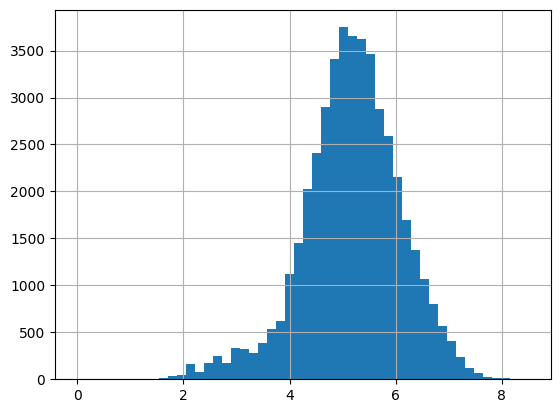

In [472]:
# normalize duration column using log transformation
import numpy as np
bank_df["duration"] = np.log(bank_df["duration"]+1)
bank_df["duration"].hist(bins=50)
plt.show()

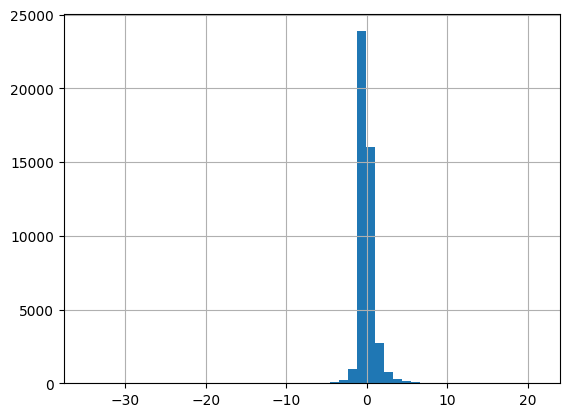

In [473]:
from sklearn.preprocessing import PowerTransformer

# normalize balance column using Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
bank_df['balance'] = pt.fit_transform(bank_df[['balance']])

# Plot the transformed balance column
bank_df['balance'].hist(bins=50)
plt.show()

In [474]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

numerical_cols = ["age", "balance", "duration", "campaign", "pdays", "previous"]
nominal_cols = ["job", "marital", "default", "housing", "loan", "contact", "poutcome"]
ordinal_cols = ["education", "month"]

log_transformer = FunctionTransformer(lambda x: np.log1p(np.maximum(x, 0) + 1e-9), validate=True)
pt = FunctionTransformer(lambda x: PowerTransformer(method='yeo-johnson').fit_transform(x), validate=True)

nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('log_transform', log_transformer, ['duration']),
        ('pt', pt, ['balance']),
        ('scaler', StandardScaler(), ["age", "campaign", "pdays", "previous"]),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
    ])

preprocessed_train_set = preprocessor.fit_transform(train_set)
pd.DataFrame(preprocessed_train_set).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27126 entries, 0 to 27125
Data columns (total 36 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       27126 non-null  float64
 1   1       27126 non-null  float64
 2   2       27126 non-null  float64
 3   3       27126 non-null  float64
 4   4       27126 non-null  float64
 5   5       27126 non-null  float64
 6   6       27126 non-null  float64
 7   7       27126 non-null  float64
 8   8       27126 non-null  float64
 9   9       27126 non-null  float64
 10  10      27126 non-null  float64
 11  11      27126 non-null  float64
 12  12      27126 non-null  float64
 13  13      27126 non-null  float64
 14  14      27126 non-null  float64
 15  15      27126 non-null  float64
 16  16      27126 non-null  float64
 17  17      27126 non-null  float64
 18  18      27126 non-null  float64
 19  19      27126 non-null  float64
 20  20      27126 non-null  float64
 21  21      27126 non-null  float64
 22

In [475]:
preprocessed_train_set_missing = MCAR2unifo(preprocessed_train_set, 80)
preprocessed_train_set_missing

/content/drive/MyDrive/projet_bi/gain_utils.py:239: UserWarning: PATTERNS at risk of being all NaN: 91
  warnings.warn(f"PATTERNS at risk of being all NaN: {nPatternsRisk}")


array([[       nan,        nan,        nan, ...,        nan, 0.        ,
               nan],
       [5.33271879,        nan,        nan, ...,        nan,        nan,
        1.        ],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        1.        ],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan, 1.41930686, ..., 0.        ,        nan,
               nan]])

In [476]:
#from gain_utils import missing_method

#preprocessed_train_set_missing, mask = missing_method(preprocessed_train_set, mechanism="mcar", method="random", missing_threshold=0.1, random_state=42)
#preprocessed_train_set_missing

In [477]:
"""from improved_gain import GAINImputer
data_x = preprocessed_train_set_missing.copy()
gain_parameters = {
    'batch_size': 8,
    'hint_rate': 0.9,
    'alpha': 1,
    'iterations': 100
}

gain_imputer = GAINImputer(gain_parameters=gain_parameters)
imputed_data = gain_imputer.fit_transform(data_x)"""


from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from sklearn.metrics import make_scorer

#Définir la grille des hyperparamètres pour KNNImputer
param_distributions = {
    "n_neighbors": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "weights": ["uniform", "distance"],
    "metric": ["nan_euclidean"],  # Seul 'nan_euclidean' est valide
    "missing_values": [np.nan]
}

# Define the RMSE scoring function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Instancier RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=KNNImputer(),
    param_distributions=param_distributions,
    n_iter=10,      # Augmenter le nombre d'itérations pour une meilleure recherche
    scoring=rmse_scorer,  # Utiliser l'erreur quadratique moyenne
    cv=3,           # Augmenter le nombre de folds pour une meilleure validation
    random_state=42,
    n_jobs=-1       # Utiliser tous les cœurs disponibles
)

# Effectuer la recherche hyperparamétrique
random_search.fit(preprocessed_train_set)  # Appliquer fit(X, y) pour ajuster les hyperparamètres

# Meilleurs paramètres trouvés
print("Best Parameters:", random_search.best_params_)

# Appliquer la transformation et l'imputation
imputed_train_set= random_search.best_estimator_.transform(preprocessed_train_set)



Best Parameters: {'weights': 'uniform', 'n_neighbors': 2, 'missing_values': nan, 'metric': 'nan_euclidean'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [478]:
def imputation_rmse(clean_data, imputed_data, missing_mask):
    """
    Calculate Root Mean Square Error (RMSE) for imputed values

    Parameters:
    -----------
    clean_data : numpy.ndarray
        The original, complete dataset
    imputed_data : numpy.ndarray
        The dataset after imputation
    missing_mask : numpy.ndarray, optional
        Mask indicating missing values in the original dataset.

    Returns:
    --------
    float
        Root Mean Square Error for the imputed values
    dict
        Detailed performance metrics
    """
    # Validate input shapes
    if clean_data.shape != imputed_data.shape:
        raise ValueError("Clean and imputed datasets must have the same shape")

    # Ensure mask is boolean
    missing_mask = missing_mask.astype(bool)

    # Calculate errors only for missing values
    errors = clean_data[missing_mask] - imputed_data[missing_mask]

    # Calculate RMSE
    rmse = np.sqrt(np.mean(errors**2))

    # Additional performance metrics
    metrics = {
        'rmse': rmse,
        'mae': np.mean(np.abs(errors)),
        'total_missing': np.sum(missing_mask),
        'missing_percentage': np.sum(missing_mask) / missing_mask.size * 100,
        'min_error': np.abs(np.min(errors)),
        'max_error': np.abs(np.max(errors)),
        'std_error': np.std(errors)
    }

    return rmse, metrics


In [479]:
preprocessed_test_set = preprocessor.transform(test_set)

In [480]:
preprocessed_test_set_missing = MCAR2unifo(preprocessed_test_set, 30)
mask_test = np.isnan(preprocessed_test_set_missing)
#preprocessed_test_set_missing, mask_test = missing_method(preprocessed_test_set, mechanism="mcar", method="random", missing_threshold=0.1, random_state=42)

In [481]:
imputed_test_set = random_search.best_estimator_.transform(preprocessed_test_set_missing)

In [482]:
def custom_imputation_error_onehot(clean_data, imputed_data, missing_mask, column_types, onehot_indices):
    """
    Calculate a weighted error metric for imputed values with one-hot encoding for categorical columns.

    Parameters:
    -----------
    clean_data : numpy.ndarray
        The original, complete dataset (in one-hot format for categorical columns).
    imputed_data : numpy.ndarray
        The dataset after imputation (in one-hot format for categorical columns).
    missing_mask : numpy.ndarray
        Mask indicating missing values in the original dataset.
    column_types : list of str
        List indicating the type of each original column: 'categorical' or 'numerical'.
    onehot_indices : dict
        A dictionary where keys are the indices of categorical columns in the original dataset,
        and values are the indices of their corresponding one-hot-encoded columns.

    Returns:
    --------
    dict
        Combined weighted error and individual errors.
    """
    from sklearn.metrics import log_loss
    # Validate input
    if clean_data.shape != imputed_data.shape:
        raise ValueError("Clean and imputed datasets must have the same shape")

    missing_mask = missing_mask.astype(bool)
    n_cols = len(column_types)

    # Separate weights for categorical and numerical columns
    n_cat = sum(1 for t in column_types if t == 'categorical')
    n_num = sum(1 for t in column_types if t == 'numerical')

    total_columns = n_cat + n_num
    w_cat = n_cat / total_columns if n_cat > 0 else 0
    w_num = n_num / total_columns if n_num > 0 else 0

    # Cross-entropy for categorical columns
    ce = 0
    if n_cat > 0:
        for col_idx, onehot_range in onehot_indices.items():
            # Get indices for one-hot encoded columns
            onehot_cols = onehot_range
            cat_clean = clean_data[:, onehot_cols]
            cat_imputed = imputed_data[:, onehot_cols]
            cat_missing_mask = missing_mask[:, onehot_cols[0]]  # Check first column in one-hot range

            # Filter rows with missing values
            if np.any(cat_missing_mask):
                clean_rows = cat_clean[cat_missing_mask]
                imputed_rows = cat_imputed[cat_missing_mask]
                ce += log_loss(clean_rows, imputed_rows)
        ce /= n_cat  # Average cross-entropy across categorical columns

    # RMSE for numerical columns
    rmse = 0
    if n_num > 0:
        num_indices = [i for i, t in enumerate(column_types) if t == 'numerical']
        num_clean = clean_data[:, num_indices]
        num_imputed = imputed_data[:, num_indices]
        num_missing_mask = missing_mask[:, num_indices]

        errors = num_clean[num_missing_mask] - num_imputed[num_missing_mask]
        rmse = np.sqrt(np.mean(errors**2))

    # Weighted sum of errors
    weighted_error = w_cat * ce + w_num * rmse

    return {
        'weighted_error': weighted_error,
        'categorical_error': ce,
        'numerical_error': rmse,
        'weights': {'categorical': w_cat, 'numerical': w_num}
    }


In [483]:
mask = np.isnan(preprocessed_train_set_missing)

# Map original column types to processed indices
n_numerical = len(numerical_cols)
n_nominal = sum([len(train_set[col].unique()) for col in nominal_cols])  # One-hot encoding expands nominal columns
n_ordinal = len(ordinal_cols)

# Assign column ranges
numerical_indices = list(range(n_numerical))
ordinal_indices = list(range(n_numerical, n_numerical + n_ordinal))
nominal_indices = list(range(n_numerical + n_ordinal, n_numerical + n_ordinal + n_nominal))

# Build the onehot_indices dictionary
onehot_indices = {}
start = n_numerical + n_ordinal
for col in nominal_cols:
    n_classes = len(train_set[col].unique())
    onehot_indices[col] = list(range(start, start + n_classes))
    start += n_classes

# Define column types (categorical or numerical)
column_types = ['numerical'] * n_numerical + ['categorical'] * (n_nominal + n_ordinal)

# Calculate the error
error_metrics = custom_imputation_error_onehot(
    clean_data=preprocessed_train_set,
    imputed_data=imputed_train_set,
    missing_mask=mask,
    column_types=column_types,
    onehot_indices=onehot_indices
)

# Output results
print("Weighted Error:", error_metrics['weighted_error'])
print("Categorical Error (CE):", error_metrics['categorical_error'])
print("Numerical Error (RMSE):", error_metrics['numerical_error'])
print("Weights:", error_metrics['weights'])

Weighted Error: 4.317533984653387e-17
Categorical Error (CE): 5.1810407815840646e-17
Numerical Error (RMSE): 0.0
Weights: {'categorical': 0.8333333333333334, 'numerical': 0.16666666666666666}


In [484]:
# Calculate the error
error_metrics_test = custom_imputation_error_onehot(
    clean_data=preprocessed_test_set,
    imputed_data=imputed_test_set,
    missing_mask=mask_test,
    column_types=column_types,
    onehot_indices=onehot_indices
)

# Output results
print("Weighted Error:", error_metrics_test['weighted_error'])
print("Categorical Error (CE):", error_metrics_test['categorical_error'])
print("Numerical Error (RMSE):", error_metrics_test['numerical_error'])
print("Weights:", error_metrics_test['weights'])

Weighted Error: 0.563923771787481
Categorical Error (CE): 0.4753428969716237
Numerical Error (RMSE): 1.0068281458667672
Weights: {'categorical': 0.8333333333333334, 'numerical': 0.16666666666666666}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2956: UserWarning: T